# Different Granularities of performing Linear Qunatization

- THe more granular is the quantization the more accurate it will be.
- However it will require more memory as will have to store more quantization parameters. like sacle, zero point.

- Per Tensor

- Per Channel (along an axis)

- Per Group (Group n elements together)


## Per Tensor Quantization

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch


def quantization_error(tensor, dequantized_tensor):
    return (dequantized_tensor - tensor).abs().square().mean()


def linear_q_with_scale_and_zero_point(
    r_tensor, scale, zero_point, dtype=torch.int8):
    """
    Performs simple linear quantization given
    the scale and zero-point.
    """

    # scale tensor and add the zero point
    scaled_and_shifted_tensor = r_tensor / scale + zero_point

    # round the tensor
    rounded_tensor = torch.round(scaled_and_shifted_tensor)

    # we need to clamp to the min/max value of the specified dtype
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    q_tensor = rounded_tensor.clamp(q_min, q_max).to(dtype)
    return q_tensor


def linear_dequantization(quantized_tensor, scale, zero_point):
    """
    Linear de-quantization
    """
    dequantized_tensor = scale * (quantized_tensor.float() - zero_point)

    return dequantized_tensor

def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """
    Plot a heatmap of tensors using seaborn
    """
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """
    A method that plots 4 matrices, the original tensor, the quantized tensor
    the de-quantized tensor and the error tensor.
    """
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))

    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')

    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')

    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))

    fig.tight_layout()
    plt.show()

def get_q_scale_and_zero_point(r_tensor, dtype=torch.int8):
    """
    Get quantization parameters (scale, zero point)
    for a floating point tensor
    """
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = r_tensor.min().item(), r_tensor.max().item()

    scale = (r_max-r_min)/(q_max-q_min)

    zero_point = q_min-(r_min/scale)

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < q_min or zero_point > q_max:
        zero_point = q_min
    else:
        # round and cast to int
        zero_point = int(round(zero_point))
    return scale, zero_point

def linear_quantization(r_tensor, n_bits, dtype=torch.int8):
    """
    linear quantization
    """

    scale, zero_point = get_q_scale_and_zero_point(r_tensor)

    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale=scale, zero_point=zero_point, dtype=dtype)

    return quantized_tensor, scale, zero_point


############# From the previous lesson(s) of "Linear Quantization II"
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max

    # return the scale
    return r_max/q_max


def linear_q_symmetric(tensor, dtype=torch.int8):
    scale = get_q_scale_symmetric(tensor)

    quantized_tensor = linear_q_with_scale_and_zero_point(tensor,
                                                     scale=scale,
                   # in symmetric quantization zero point is = 0
                                                    zero_point=0,
                                                      dtype=dtype)

    return quantized_tensor, scale
###################################

In [2]:
# test tensor
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [3]:
# symm quantization
quantized_tensor, scale = linear_q_symmetric(test_tensor)

In [4]:
# dequan
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

In [6]:
#plot
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)
dequantized_tensor

tensor([[ 189.3213,  -11.4740,  728.6000],
        [  91.7921,  298.3244, -183.5842],
        [   0.0000,  682.7039,  246.6913]])

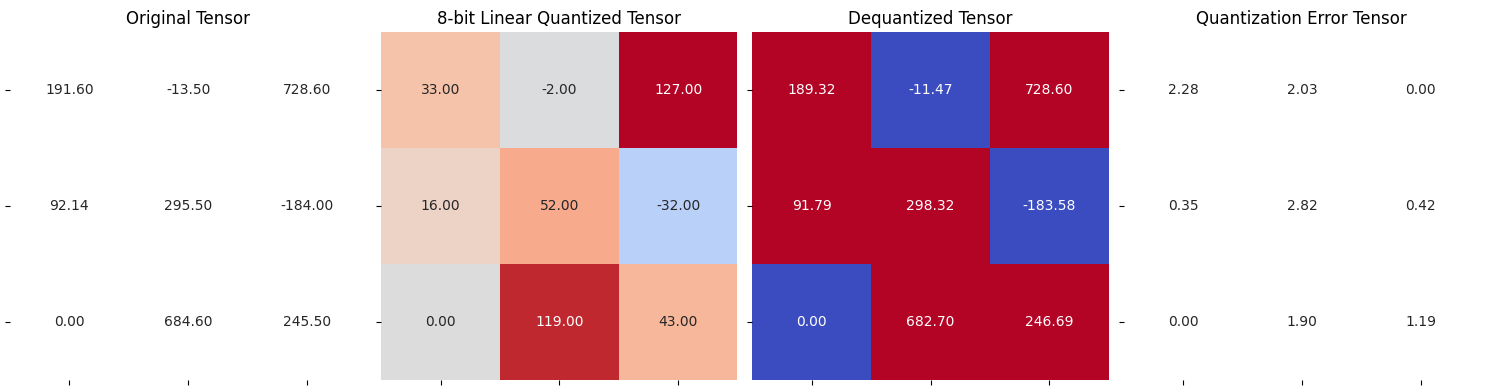

In [8]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

- We see Original tensor and dequantized tensor are some what similar.
- Error is still low.


In [9]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 2.5091912746429443


## Per Channel Quantization (each rows or cols)

1.   Memory required is low.
2.   Usual done to quantize model into 8 bit.
- Implement `Per Channel` Symmetric Quantization
- `dim` parameter decides if it needs to be along the rows or columns


In [ ]:
# Per channel Qunatization
def linear_q_symmetric_per_channel(tensor,dim,dtype=torch.int8):



    return quantized_tensor, scale

In [10]:
# test tensor
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

- `dim = 0`, along the rows
- `dim = 1`, along the columns


In [12]:
dim=0
output_dim = test_tensor.shape[dim]
output_dim

3

In [13]:
scale = torch.zeros(output_dim)
scale

tensor([0., 0., 0.])

In [14]:
# Iterate through each row to calculate its scale.
for index in range(output_dim):
    sub_tensor = test_tensor.select(dim,index)
    # print(sub_tensor)
    scale[index] = get_q_scale_symmetric(sub_tensor)

In [16]:
# we store scale related to each row insde the tensor
scale

tensor([5.7370, 2.3268, 5.3906])

processing to reshape the scale
- so that when we devide the original tenso by the tensor scale, each column is divided by the correct scale.

In [20]:

scale_shape = [1] * test_tensor.dim()
scale_shape

[1, 1]

In [21]:
scale_shape[dim] = -1
scale_shape

[-1, 1]

In [22]:
scale = scale.view(scale_shape)
# copy to be used later
copy_scale = scale

scale

tensor([[5.7370],
        [2.3268],
        [5.3906]])

In [23]:
# Understanding view
m= torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [24]:
s=torch.tensor([1,5,10])
s

tensor([ 1,  5, 10])

In [26]:
s.shape

torch.Size([3])

In [34]:
print(s.view(1,3))
s.view(1,3).shape

tensor([[ 1,  5, 10]])


torch.Size([1, 3])

In [33]:
print(s.view(1,-1))
s.view(1,-1).shape

tensor([[ 1,  5, 10]])


torch.Size([1, 3])

In [35]:
print(s.view(-1,1))
s.view(-1,1).shape

tensor([[ 1],
        [ 5],
        [10]])


torch.Size([3, 1])

#### Along the row division

In [36]:
scale = torch.tensor([[1], [5], [10]])

In [37]:
scale.shape

torch.Size([3, 1])

In [38]:
m / scale

tensor([[1.0000, 2.0000, 3.0000],
        [0.8000, 1.0000, 1.2000],
        [0.7000, 0.8000, 0.9000]])

#### Along the column

In [39]:
scale = torch.tensor([[1, 5, 10]])

In [40]:
scale.shape

torch.Size([1, 3])

In [41]:
m / scale

tensor([[1.0000, 0.4000, 0.3000],
        [4.0000, 1.0000, 0.6000],
        [7.0000, 1.6000, 0.9000]])

#### QUnatizing the tensor|

In [42]:
# the scale you got earlier
scale = copy_scale

scale

tensor([[5.7370],
        [2.3268],
        [5.3906]])

In [43]:
scale.shape

torch.Size([3, 1])

In [45]:
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor, scale=scale, zero_point=0)
quantized_tensor

tensor([[ 33,  -2, 127],
        [ 40, 127, -79],
        [  0, 127,  46]], dtype=torch.int8)

In [46]:
# Now, put all this in `linear_q_symmetric_per_channel` function defined earlier.
def linear_q_symmetric_per_channel(r_tensor, dim, dtype=torch.int8):

    output_dim = r_tensor.shape[dim]
    # store the scales
    scale = torch.zeros(output_dim)

    # we itrate through the scale and for the each index we get the sub tensor
    for index in range(output_dim):
        sub_tensor = r_tensor.select(dim, index)
        #storing scale in the index position
        scale[index] = get_q_scale_symmetric(sub_tensor, dtype=dtype)

    # reshape the scale
    scale_shape = [1] * r_tensor.dim()
    scale_shape[dim] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale=scale, zero_point=0, dtype=dtype)

    return quantized_tensor, scale


In [54]:
# out test tensor
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [48]:
### along the rows (dim = 0)
quantized_tensor_0, scale_0 = linear_q_symmetric_per_channel(
    test_tensor, dim=0)

### along the columns (dim = 1)
quantized_tensor_1, scale_1 = linear_q_symmetric_per_channel(
    test_tensor, dim=1)

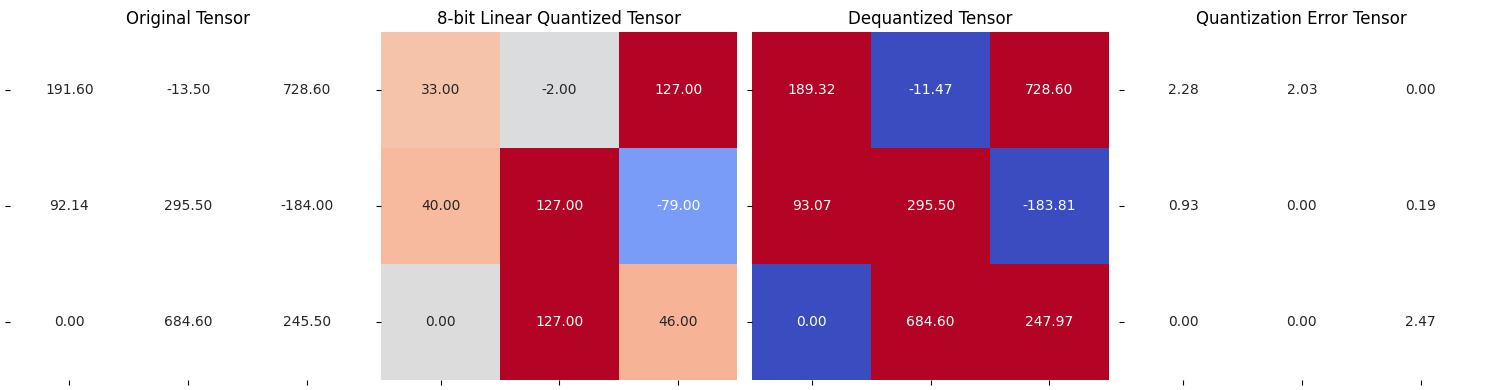

In [55]:
# Ploting along the rows
dequantized_tensor_0 = linear_dequantization(
    quantized_tensor_0, scale_0, 0) # zero point is zero

plot_quantization_errors(
    test_tensor, quantized_tensor_0, dequantized_tensor_0)

- we see org tensor and the dequn similar
- loss is also low

In [50]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_0)}""")

Quantization Error : 1.8084441423416138


here quant error (1.8) is less then per tensor error (2.5)

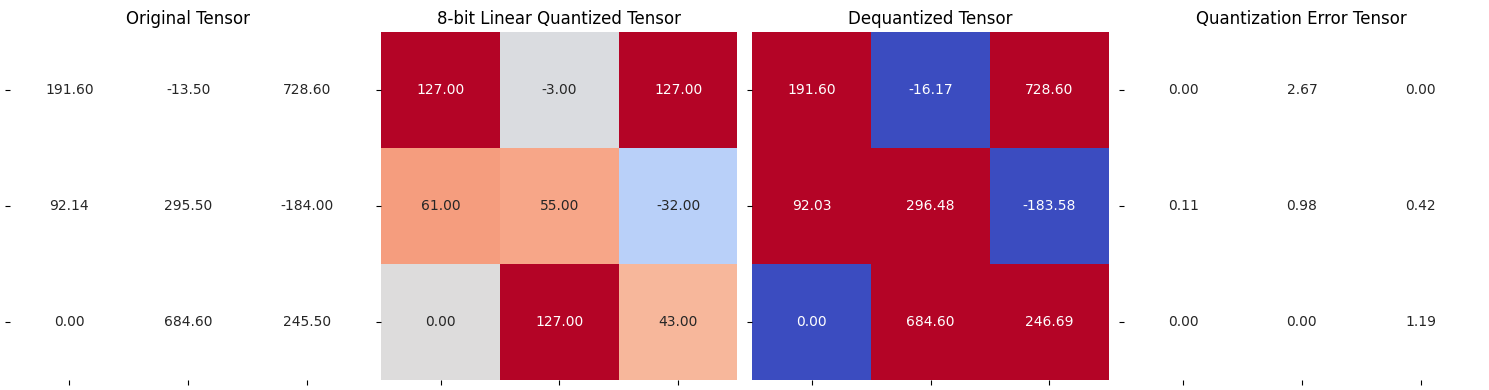

In [52]:
#Plot the quantization error for along the columns.
dequantized_tensor_1 = linear_dequantization(
    quantized_tensor_1, scale_1, 0)

plot_quantization_errors(
    test_tensor, quantized_tensor_1, dequantized_tensor_1, n_bits=8)



In [53]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_1)}""")

Quantization Error : 1.0781488418579102


- where the erorr is much more lower

## Per Group Qunatization
- Can require a lot more memory
  - Lets say we want t quantize a tensor in 4-bit and we choose group_size =32, symmetric mode (z-0), we store the same scales in FP16.

  - It means that we actually quantizing the tensor in 4.5 bits since we have:
    - 4 bit (each element is stored in 4 bit)
    - 16/32 bit (scale in 16 bits for every 32 elements)

In [56]:
#For simplicity, you'll quantize a 2D tensor along the rows.
def linear_q_symmetric_per_group(tensor, group_size,
                                 dtype=torch.int8):

    t_shape = tensor.shape
    # the shape of the tensor along the rows is indeed divisible by group size
    assert t_shape[1] % group_size == 0
    # restricting the tensor to dimenssion 2
    assert tensor.dim() == 2
    #Reshape the tensor so that we have rows of group size elements
    # using view
    tensor = tensor.view(-1, group_size)
    #qunat
    quantized_tensor, scale = linear_q_symmetric_per_channel(
                                tensor, dim=0, dtype=dtype)
    # reshape to tshape
    quantized_tensor = quantized_tensor.view(t_shape)

    return quantized_tensor, scale

In [57]:
def linear_dequantization_per_group(quantized_tensor, scale,
                                    group_size):
    #shape
    q_shape = quantized_tensor.shape
    # Reshape q_t
    quantized_tensor = quantized_tensor.view(-1, group_size)
    #deq using linear_deq
    dequantized_tensor = linear_dequantization(quantized_tensor,
                                               scale, 0)
    #reshare with the shape of the orig tensor
    dequantized_tensor = dequantized_tensor.view(q_shape)

    return dequantized_tensor

In [58]:
# size 6x6
test_tensor = torch.rand((6, 6))

In [59]:
# group size 3
group_size = 3

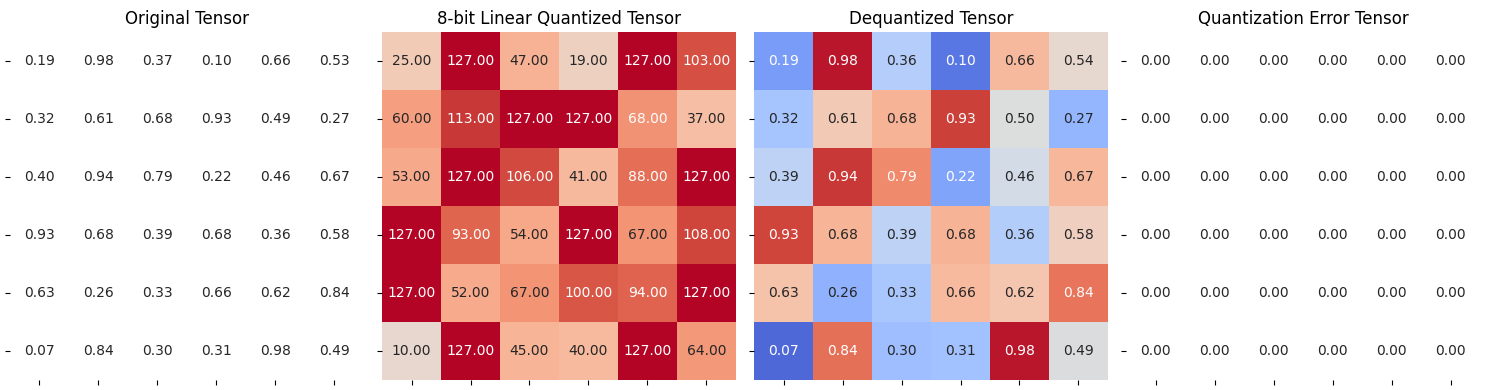

In [60]:
quantized_tensor, scale = linear_q_symmetric_per_group(
    test_tensor, group_size=group_size)

dequantized_tensor = linear_dequantization_per_group(
    quantized_tensor, scale, group_size=group_size)

plot_quantization_errors(
    test_tensor, quantized_tensor, dequantized_tensor)

- every three elements in each row, have the max value 127, it shows that we indeed managed to quantize each three elements in this matrix along the rows.
- We see similarity in original ans dequantized tensor
- error is very very low

In [61]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 2.3437332856701687e-06


- Loss is less the per tensor but greater than per row/col